# tf2 vanilla autoencoder 로 MNIST Reconstruct 

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU[0] is ready')
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)
else:
    print('Please check GPU available')
    
import os
import sys
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
from tensorflow import feature_column as fc
import tensorflow_datasets as tfds
plt.rcParams["font.family"] = 'NanumBarunGothic'
TENSORBOARD_BINARY = '/home/hoondori/anaconda3/envs/ai/bin/tensorboard'
os.environ['TENSORBOARD_BINARY'] =  TENSORBOARD_BINARY 

GPU[0] is ready


In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt

# MNIST 데이터 확보

In [2]:
np.random.seed(11)
tf.random.set_seed(11)
batch_size = 256
max_epochs = 50
learning_rate = 1e-3
momentum = 8e-1
hidden_dim = 128
original_dim = 784

In [4]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))

training_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
training_dataset

<BatchDataset shapes: (None, 784), types: tf.float32>

# 모델 정의

In [16]:
class Encoder(tf.keras.layers.Layer):
    
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=hidden_dim, activation=tf.nn.relu)
        
    def call(self, input_features):
        x = self.hidden_layer(input_features)
        return x

class Decoder(tf.keras.layers.Layer):
    
    def __init__(self, original_dim):
        super(Decoder, self).__init__()
        self.output_layer = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.relu)
        
    def call(self, encoded):
        x = self.output_layer(encoded)
        return x
    
class Autoencoder(tf.keras.Model):
    
    def __init__(self, hidden_dim, original_dim):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(hidden_dim=hidden_dim)
        self.decoder = Decoder(original_dim=original_dim)
        
    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed
    
    
    
autoencoder = Autoencoder(hidden_dim=hidden_dim, original_dim=original_dim)
autoencoder.build(input_shape=(None, 784))
autoencoder.call(tf.keras.layers.Input(shape = (784)))
autoencoder.summary()
#tf.keras.utils.plot_model(autoencoder, show_shapes=True)

Model: "autoencoder_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_11 (Encoder)         (None, 128)               100480    
_________________________________________________________________
decoder_11 (Decoder)         (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________


# 학습

In [17]:
def loss(preds, real):
    return tf.reduce_mean(tf.square(tf.subtract(preds, real)))

def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        preds = model(original)
        reconstruction_error = loss(preds, original)
    gradients = tape.gradient(reconstruction_error, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    return reconstruction_error 

def train_loop(model, opt, loss, dataset, epochs=20):
    for epoch in range(epochs):
        epoch_loss = 0
        for step, batch_features in enumerate(dataset):
            loss_values = train(loss, model, opt, batch_features)
            epoch_loss += loss_values
        model.loss.append(epoch_loss)
        print('Epoch {}/{}. Loss: {:.3f}'.format(epoch + 1, epochs, epoch_loss.numpy()))

autoencoder = Autoencoder(hidden_dim=hidden_dim, original_dim=original_dim)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(autoencoder, opt, loss, training_dataset, epochs=max_epochs)        

Epoch 1/50. Loss: 4.813
Epoch 2/50. Loss: 2.884
Epoch 3/50. Loss: 2.776
Epoch 4/50. Loss: 2.726
Epoch 5/50. Loss: 2.664
Epoch 6/50. Loss: 2.637
Epoch 7/50. Loss: 2.592
Epoch 8/50. Loss: 2.617
Epoch 9/50. Loss: 2.587
Epoch 10/50. Loss: 2.583
Epoch 11/50. Loss: 2.577
Epoch 12/50. Loss: 2.578
Epoch 13/50. Loss: 2.578
Epoch 14/50. Loss: 2.570
Epoch 15/50. Loss: 2.573
Epoch 16/50. Loss: 2.586
Epoch 17/50. Loss: 2.558
Epoch 18/50. Loss: 2.596
Epoch 19/50. Loss: 2.562
Epoch 20/50. Loss: 2.572
Epoch 21/50. Loss: 2.538
Epoch 22/50. Loss: 2.584
Epoch 23/50. Loss: 2.569
Epoch 24/50. Loss: 2.561
Epoch 25/50. Loss: 2.539
Epoch 26/50. Loss: 2.584
Epoch 27/50. Loss: 2.557
Epoch 28/50. Loss: 2.569
Epoch 29/50. Loss: 2.560
Epoch 30/50. Loss: 2.591
Epoch 31/50. Loss: 2.567
Epoch 32/50. Loss: 2.568
Epoch 33/50. Loss: 2.579
Epoch 34/50. Loss: 2.572
Epoch 35/50. Loss: 2.542
Epoch 36/50. Loss: 2.610
Epoch 37/50. Loss: 2.568
Epoch 38/50. Loss: 2.525
Epoch 39/50. Loss: 2.597
Epoch 40/50. Loss: 2.556
Epoch 41/

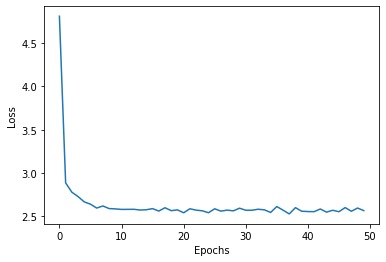

In [18]:
plt.plot(range(max_epochs), autoencoder.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Reconstruct 시각화

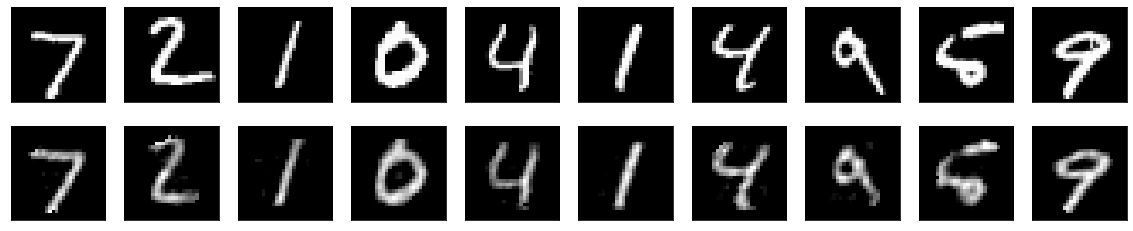

In [25]:
number = 10 
plt.figure(figsize=(20,4))
for index in range(number):
    # original
    ax = plt.subplot(2, number, index+1)
    plt.imshow(x_test[index].reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # reconstructed
    ax = plt.subplot(2, number, index+1+number)  # 다음 줄
    plt.imshow(autoencoder(x_test)[index].numpy().reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()